In [133]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.neural_network import MLPRegressor

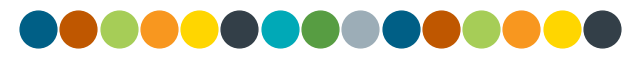

In [134]:
# https://brand.utexas.edu/identity/color/
import random
from cycler import cycler

random.Random(12).shuffle(colors := '#bf5700 #f8971f #ffd600 #a6cd57 #579d42 #00a9b7 #005f86 #9cadb7 #333f48'.split(' '))
plt.figure(figsize=(8,0.5))
for i in range(15): plt.scatter(i,0,s=700)
plt.axis('off')
plt.show()
plt.rc('axes', prop_cycle=cycler(color=colors))

In [135]:
# Train/Test data
train = pd.read_csv(r'training_dataset.csv')
blackscholes = pd.read_csv(r'testing_blackscholes.csv')
bodytrack = pd.read_csv(r'testing_bodytrack.csv')
train.head()

,total_watts,w_big,w_little,w_gpu,w_mem,usage_c4,usage_c5,usage_c6,usage_c7,temp4,temp5,temp6,temp7,temp_gpu,freq_big_cluster
0,3.065,0.474810,0.033012,0.096321,0.048800,0.0,0.0,0.0,0.0,49,53,52,48,47,1000000000
1,2.706,0.235620,0.032095,0.096515,0.032940,0.0,0.0,0.0,0.0,48,52,52,48,47,1000000000
2,2.706,0.235620,0.034846,0.096515,0.032940,0.0,0.0,0.0,0.0,48,52,52,48,47,1000000000
3,2.637,0.234685,0.034846,0.096321,0.037758,0.0,0.0,0.0,0.0,48,51,51,48,47,1000000000
4,2.637,0.233750,0.033929,0.096321,0.032886,0.0,0.0,0.0,0.0,48,51,51,48,47,1000000000


In [136]:
# Drop power features
power_features = [c for c in train.columns if 'w' in c]
[df.drop(columns=power_features, inplace=True) for df in (train, blackscholes, bodytrack)]
train.head()

,usage_c4,usage_c5,usage_c6,usage_c7,temp4,temp5,temp6,temp7,temp_gpu,freq_big_cluster
0,0.0,0.0,0.0,0.0,49,53,52,48,47,1000000000
1,0.0,0.0,0.0,0.0,48,52,52,48,47,1000000000
2,0.0,0.0,0.0,0.0,48,52,52,48,47,1000000000
3,0.0,0.0,0.0,0.0,48,51,51,48,47,1000000000
4,0.0,0.0,0.0,0.0,48,51,51,48,47,1000000000


In [137]:
# Recommended data transforms
for i in range(4, 8):
    train[f'temp{i}'] = train[f'temp{i}'] / 100
    blackscholes[f'temp{i}'] = blackscholes[f'temp{i}'] / 100
    bodytrack[f'temp{i}'] = bodytrack[f'temp{i}'] / 100

train['temp_gpu'] = train['temp_gpu'] / 100
blackscholes['temp_gpu'] = blackscholes['temp_gpu'] / 100
bodytrack['temp_gpu'] = bodytrack['temp_gpu'] / 100

train['freq_big_cluster'] = train['freq_big_cluster'] / 2000000000
blackscholes['freq_big_cluster'] = blackscholes['freq_big_cluster'] / 2000000000
bodytrack['freq_big_cluster'] = bodytrack['freq_big_cluster'] / 2000000000

   usage_c4  usage_c5  usage_c6  usage_c7  temp4  temp5  temp6  temp7  \
0       0.0       0.0       0.0       0.0   0.49   0.53   0.52   0.48   
1       0.0       0.0       0.0       0.0   0.48   0.52   0.52   0.48   
2       0.0       0.0       0.0       0.0   0.48   0.52   0.52   0.48   
3       0.0       0.0       0.0       0.0   0.48   0.51   0.51   0.48   
4       0.0       0.0       0.0       0.0   0.48   0.51   0.51   0.48   

   temp_gpu  freq_big_cluster  
0      0.47               0.5  
1      0.47               0.5  
2      0.47               0.5  
3      0.47               0.5  
4      0.47               0.5  
   temp4  temp5  temp6  temp7
0   0.48   0.52   0.52   0.48
1   0.48   0.52   0.52   0.48
2   0.48   0.51   0.51   0.48
3   0.48   0.51   0.51   0.48
4   0.48   0.51   0.51   0.48
(5414, 10) (5414, 4)


<AxesSubplot: ylabel='Count'>

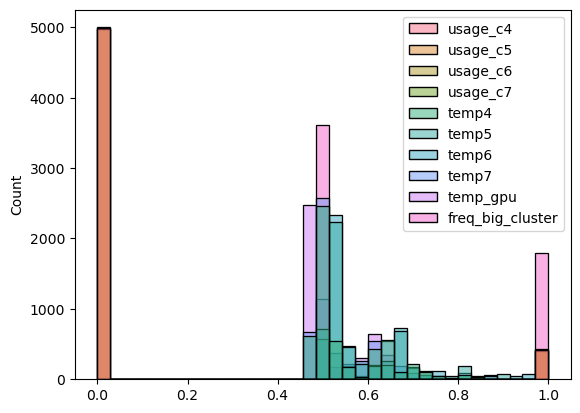

In [138]:
# Separate target features and parameters
targets = [f'temp{i}' for i in range(4,8)]
split = lambda df: (df[:-1], df[targets][1:].reset_index(drop=True))

train, train_target = split(train)
blackscholes, blackscholes_target = split(blackscholes)
bodytrack, bodytrack_target = split(bodytrack)

print(train.head())
print(train_target.head())
print(train.shape, train_target.shape)
sns.histplot(train)

In [150]:
regressors = {f'core{i}':MLPRegressor(
    hidden_layer_sizes=(128,64,32),
    activation='relu',
    alpha=0,
    random_state=42
) for i in range(4, 8)}

# train a model per core
for core, model in regressors.items():
    model.fit(train, train_target['temp'+core[-1]])

# test each model
predictions_blackscholes = {}
predictions_bodytrack = {}
scores = {}
for core, model in regressors.items():
    predictions_blackscholes[core] = model.predict(blackscholes)
    predictions_bodytrack[core] = model.predict(bodytrack)

    scores['blackscholes '+core] = model.score(
            blackscholes, blackscholes_target['temp'+core[-1]])
    scores['bodytrack '+core] = model.score(
            bodytrack, bodytrack_target['temp'+core[-1]])

In [151]:
from pprint import pprint
print('scores:')
pprint(scores)

scores:
{'blackscholes core4': 0.9411125340893638,
 'blackscholes core5': 0.9438795752948597,
 'blackscholes core6': 0.9363340508504558,
 'blackscholes core7': 0.9501809638065675,
 'bodytrack core4': 0.9218058929971183,
 'bodytrack core5': 0.9301181137517667,
 'bodytrack core6': 0.9289098903369438,
 'bodytrack core7': 0.8935201049510861}


In [178]:
def plot_results(predictions, target_df, cores=[f'core{i}' for i in range(4,8)], title='', filename=None):
    fig, ax = plt.subplots(1, len(cores), figsize=((8, 10, 12, 12)[len(cores)-1],4))
    for i, key in enumerate(cores):
        cur_ax = ax[i] if len(cores) > 1 else ax
        if i != 0: cur_ax.yaxis.set_ticklabels([])
        cur_ax.plot(target_df.to_numpy().T[i], label=key+' actual')
        cur_ax.plot(predictions[key], label=key+' predicted')
        cur_ax.set_ylim((0.5, 1.0))
        cur_ax.set_xlim((0, target_df.shape[0]))
        cur_ax.grid()
        cur_ax.legend(loc='lower center')
    plt.title(title)
    plt.tight_layout()
    if filename is not None: plt.savefig(filename)
    plt.show()


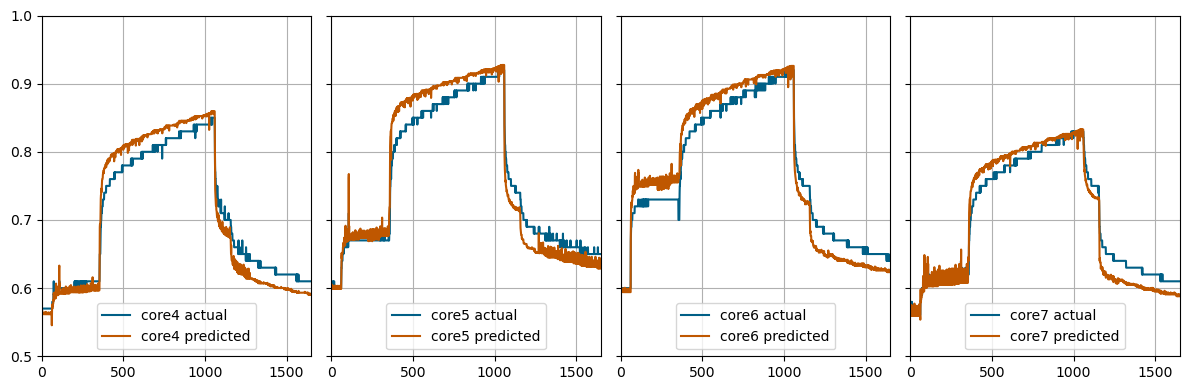

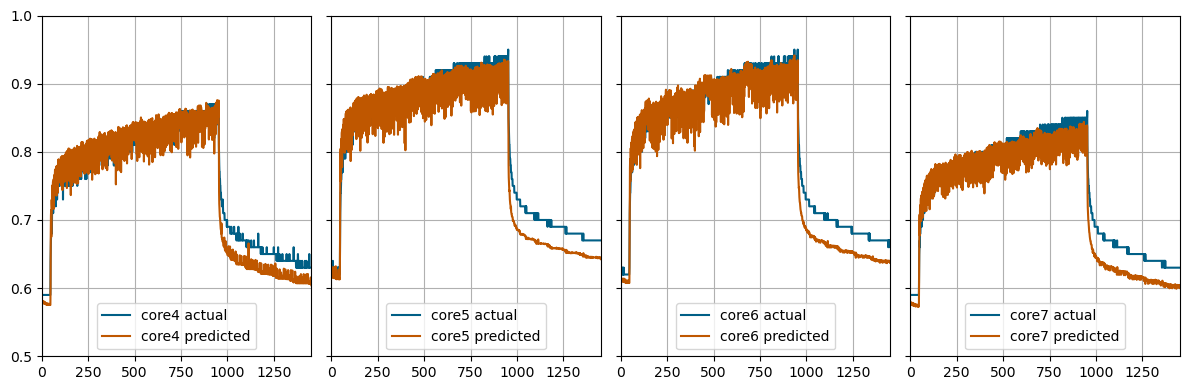

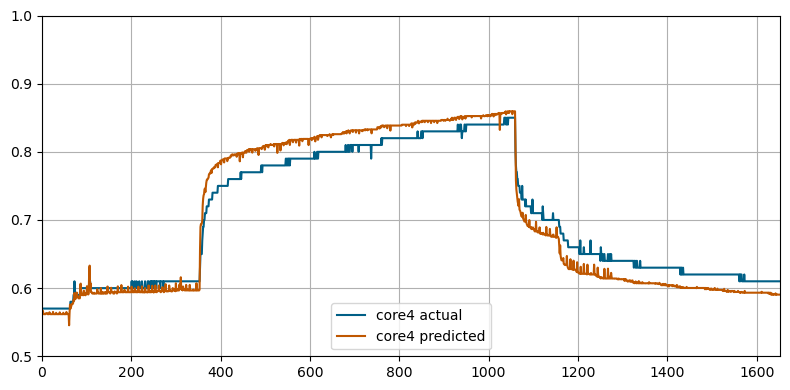

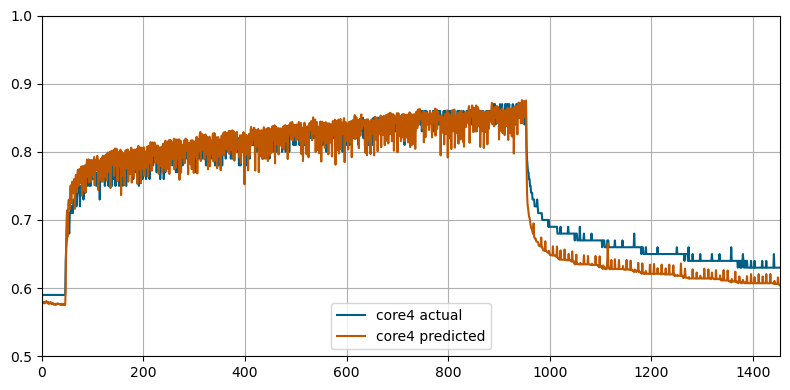

In [180]:
plot_results(predictions_blackscholes, blackscholes_target)
plot_results(predictions_bodytrack, bodytrack_target)

# submit these
plot_results(predictions_blackscholes, blackscholes_target, cores=['core4'])
plot_results(predictions_bodytrack, bodytrack_target, cores=['core4'])